In [1]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import PredefinedSplit
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
from model_pipeline import get_train_test, MissingValueTransformer, \
    CreateFeaturesTransformer, searcher_builder, data_formatted, \
    get_metrics, get_classification_metrics
from models import TorchRegressor

In [3]:
# Constants
RANDOM_STATE = 42
VALIDATION_PORTION = 0.2
FEATURES = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 
            'PT08.S5(O3)', 'T', 'RH', 'AH']
TARGET = ['NMHC(GT)', 'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
TARGET_ENOUGH=['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

In [4]:
# Global
metrics_all = {}
train_dataset, test_dataset = get_train_test()
train_dataset_NMHC, test_dataset_NMHC = get_train_test(if_NMHC=True)

# Environment Preparation

In [5]:
# run this cell above

# Regression

In [19]:
short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6]}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
def train_models(features_config: dict, feature_set_name: str):
    for target in TARGET:
        print(f"Processing target: {target}")
        X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
            train_dataset, test_dataset, target, params=features_config
        ) if target != 'NMHC(GT)' else data_formatted(
            train_dataset_NMHC, test_dataset_NMHC, target, params=features_config
        )

        model = TorchRegressor()

        hyperspace = {
            "model__lr": Real(1e-6, 1e-1, prior="log-uniform"),
            "model__hidden": Integer(128, 256),
            "model__epochs": Categorical([60]),
            "model__dropout": Real(0.1, 0.3)
        }

        nn_opt = searcher_builder(hyperspace, model, X_train.shape[0])
        nn_opt.fit(X_train, Y_train)
        pickle.dump(nn_opt, open(f'regression_searchers/reg_nn_{target}_{feature_set_name}.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)
Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)


In [20]:
from sklearn.linear_model import LinearRegression
short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6]}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
def train_models(features_config: dict, feature_set_name: str):
    for target in TARGET:
        print(f"Processing target: {target}")
        X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
            train_dataset, test_dataset, target, params=features_config
        ) if target != 'NMHC(GT)' else data_formatted(
            train_dataset_NMHC, test_dataset_NMHC, target, params=features_config
        )

        model = LinearRegression()

        hyperspace = {
            "model__fit_intercept": Categorical([True]),
        }

        nn_opt = searcher_builder(hyperspace, model, X_train.shape[0], iters=1)
        nn_opt.fit(X_train, Y_train)
        pickle.dump(nn_opt, open(f'regression_searchers/reg_linear_{target}_{feature_set_name}.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)
Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)


In [ ]:
from sklearn.linear_model import LinearRegression
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
for target in TARGET:

    print(f"Processing target: {target}")
    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target, params=long_features
    ) if target != 'NMHC(GT)' else data_formatted(
        train_dataset_NMHC, test_dataset_NMHC, target, params=long_features
    )

    model = LinearRegression()

    hyperspace = {
    "model__fit_intercept": Categorical([True]),
    }

    nn_opt = searcher_builder(hyperspace, model, X_train.shape[0], iters=1)
    nn_opt.fit(X_train, Y_train)
    pickle.dump(nn_opt, open(f'regression_searchers/reg_linear_{target}_long.pkl', 'wb'))

Processing target: NMHC(GT)
Processing target: CO(GT)
Processing target: C6H6(GT)
Processing target: NOx(GT)
Processing target: NO2(GT)


In [10]:
train_dataset, test_dataset = get_train_test(if_NMHC=True)

In [ ]:
train_dataset, test_dataset = get_train_test(if_NMHC=True)
X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
    train_dataset, test_dataset, 'NMHC(GT)', params={'lags': [1,3,6,12,24], 'window_sizes': [3,6,12]}
)

model = LinearRegression()

hyperspace = {
    "model__fit_intercept": Categorical([True]),
}

linear_regression_opt = searcher_builder(hyperspace, model, X_train.shape[0], iters=1)
linear_regression_opt.fit(X_train, Y_train)
pickle.dump(linear_regression_opt, open('regression_searchers/reg_linear_nmhc_short.pkl', 'wb'))

# Classification

In [10]:
from sklearn.svm import SVC

short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6]}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
def train_models(features_config: dict, feature_set_name: str):
    target = 'CO(GT)'
    print(f"Processing target: {target}")
    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target, params=features_config, reg=False
    )

    for i,target_lag in enumerate([1,6,12,24]):
        model = SVC()

        hyperspace = {
        "model__C": Real(1e-3, 1e+3, prior="log-uniform"),
        "model__gamma": Real(1e-4, 1e-1, prior="log-uniform")
        }

        opt = searcher_builder(hyperspace, model, X_train.shape[0], reg=False)
        opt.fit(X_train, Y_train[:, i])
        pickle.dump(opt, open(f'classification_searchers/cls_svc_{target}_{feature_set_name}_{target_lag}.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: CO(GT)


c:\LocalFile\9417 Project\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000.0, 0.0001] before, using random point [6.618419316804846, 0.002985201914615943]
  warnings.warn(
c:\LocalFile\9417 Project\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000.0, 0.0001] before, using random point [0.3296114109432843, 0.020114228787757323]
  warnings.warn(


Processing target: CO(GT)


In [7]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

short_features = {'lags': [1,3,6,12,24], 'window_sizes': [3,6]}
long_features = {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
def train_models(features_config: dict, feature_set_name: str):
    target = 'CO(GT)'
    print(f"Processing target: {target}")
    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target, params=features_config, reg=False
    )

    for i,target_lag in enumerate([1,6,12,24]):
        model = XGBClassifier()

        hyperspace = {
            "model__n_estimators": Integer(50, 100),
            "model__learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
            "model__max_depth": Integer(3, 5),
            "model__min_child_weight": Integer(1, 10),
            "model__subsample": Real(0.5, 1.0),
            "model__colsample_bytree": Real(0.5, 1.0),
            "model__gamma": Real(1e-8, 1.0, prior="log-uniform"),
            "model__reg_alpha": Real(1e-8, 10.0, prior="log-uniform"),
            "model__reg_lambda": Real(1e-8, 10.0, prior="log-uniform"),
            "model__tree_method": Categorical(["hist"]),
            "model__device": Categorical(["cuda"]),
        }
        opt = searcher_builder(hyperspace, model, X_train.shape[0], reg=False)
        opt.fit(X_train, Y_train[:, i])
        pickle.dump(opt, open(f'classification_searchers/cls_gbc_{target}_{feature_set_name}_{target_lag}.pkl', 'wb'))
train_models(short_features, 'short')
train_models(long_features, 'long')

Processing target: CO(GT)
Processing target: CO(GT)


# Evaluation

In [6]:
metrics_all = {}

folder = "./regression_searchers"   # 你的文件夹

feature_sets = {
    'short': {'lags': [1,3,6,12,24], 'window_sizes': [3,6]},
    'long': {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
} 

def load_opt_from_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

for filename in os.listdir(folder):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder, filename)

    # ------- 1. 加载 opt -------
    opt = load_opt_from_pkl(file_path)

    # ------- 2. 从文件名提取目标列名 eg. CO(GT) -------
    # 文件名格式：
    #    reg_linear_CO(GT)_long.pkl
    #    reg_nn_NOx(GT)_short.pkl
    # => 我们取第三段（split("_")[2]）
    try:
        name_parts = filename.replace(".pkl", "").split("_")
        target_column = name_parts[2]     # eg. CO(GT)
        feature_set = name_parts[3]     # eg. long / short
    except:
        print(f"[WARN] 文件名格式无法解析：{filename}")
        continue

    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target_column, feature_sets[feature_set]
    ) if target_column != 'NMHC(GT)' else data_formatted(
        train_dataset_NMHC, test_dataset_NMHC, target_column, feature_sets[feature_set]
    )
    metrics = get_metrics(opt, 
                        X_test, Y_test, Y_baseline, scaler_Y, target_column)
    key = filename.replace(".pkl", "")
    metrics_all[key] = metrics

In [5]:
metrics_cls = {}
folder = "./classification_searchers"   # 你的文件夹
feature_sets = {
    'short': {'lags': [1,3,6,12,24], 'window_sizes': [3,6]},
    'long': {'lags': [1,3,6,12,24],'window_sizes': [12,24]}
} 

def load_opt_from_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

for filename in os.listdir(folder):
    if not filename.endswith(".pkl"):
        continue

    file_path = os.path.join(folder, filename)

    # ------- 1. 加载 opt -------
    opt = load_opt_from_pkl(file_path)

    # ------- 2. 从文件名提取目标列名 eg. CO(GT) -------
    # 文件名格式：
    #    reg_linear_CO(GT)_long.pkl
    #    reg_nn_NOx(GT)_short.pkl
    # => 我们取第三段（split("_")[2]）
    try:
        name_parts = filename.replace(".pkl", "").split("_")
        target_column = 'CO(GT)'    # eg. CO(GT)
        feature_set = name_parts[3]     # eg. long / short
        lag = name_parts[4]     # eg. 1 / 6 / 12 /24
    except:
        print(f"[WARN] 文件名格式无法解析：{filename}")
        continue

    X_train, Y_train, X_test, Y_test, Y_baseline, scaler_Y = data_formatted(
        train_dataset, test_dataset, target_column, feature_sets[feature_set], reg=False
    )
    Y_test = Y_test[:, ['1','6','12','24'].index(lag)]  # 只取对应lag的列
    Y_baseline = Y_baseline[:, ['1','6','12','24'].index(lag)]  # 只取对应lag的列
    metrics = get_classification_metrics(opt, 
                        X_test, Y_test, Y_baseline, target_column)
    key = filename.replace(".pkl", "")
    metrics_cls[key] = metrics

c:\LocalFile\9417 Project\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:50:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
import pandas as pd

def rmse_and_improvement_table(metrics_all):
    rows = []
    for model_name, m in metrics_all.items():
        rmse = m["rmse"]
        improvements = m["improvement_over_baseline_percentage"]
        var = m["column"]
        

        # improvements 是数组 → 每个 index 对应一行
        for i, imp in enumerate(improvements):
            rows.append({
                "target_column": var,
                "model": model_name,
                "time_horizon": f"_{['01','06','12','24'][i]}h",
                "rmse": rmse,
                "improvement_%": imp
            })

    df = pd.DataFrame(rows)
    df = df.sort_values(["target_column", "time_horizon","model"])
    return df

rmse_imp_df = rmse_and_improvement_table(metrics_cls)
rmse_imp_df.to_csv("./metrics/cls_accuracy_and_improvement_all_models.csv", index=False)


In [13]:
def rmse_and_improvement_table(metrics_cls):
    rows = []
    for model_name, m in metrics_cls.items():
        accuracy = m["accuracy"]
        improvements = m["improvement_over_baseline_percentage"]
        var = m["column"]

        # improvements 是数组 → 每个 index 对应一行
        rows.append({
            "target_column": var,
            "model": model_name,
            "time_horizon": f'{model_name.split("_")[-1]:0>2}',  # 从模型名中提取时间范围
            "accuracy": accuracy,
            "improvement_%": improvements
        })

    df = pd.DataFrame(rows)
    df = df.sort_values(["target_column", "time_horizon","model"])
    return df

rmse_imp_df = rmse_and_improvement_table(metrics_cls)
rmse_imp_df.to_csv("./metrics/cls_accuracy_and_improvement_all_models.csv", index=False)

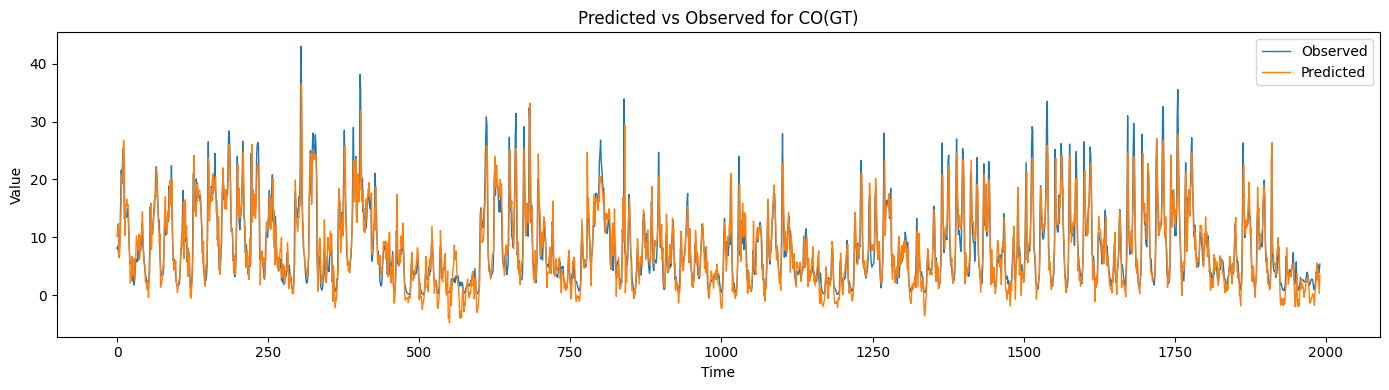

In [10]:
def plot_pred_vs_true(timestamps, y_true, y_pred, title="Predicted vs Observed"):
    plt.figure(figsize=(14, 4))
    plt.plot(timestamps, y_true, label="Observed", linewidth=1)
    plt.plot(timestamps, y_pred, label="Predicted", linewidth=1)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pred_vs_true(np.arange(len(metrics_all['reg_linear_C6H6(GT)_long']['Y_test'][:,0])), 
                  metrics_all['reg_linear_C6H6(GT)_long']['Y_test'][:,0],metrics_all['reg_linear_C6H6(GT)_long']['Y_pred'][:,0], title="Predicted vs Observed for CO(GT)")